# Image Segmentation by unsupervised Learning

## import libraries

In [627]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import random
import os

## load data

In [628]:
directory_data  = './'
filename_data   = 'assignment_10_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))
image_clean     = torch.from_numpy(data['real_images']).float()

## custom data loader for the PyTorch framework

In [629]:
class dataset (Dataset):
    def  __init__(self, data, std_noise):

        noise = torch.randn(data.size()) * std_noise

        self.clean  = data
        self.noisy  = data + noise 

    def __getitem__(self, index):

        clean   = self.clean[index]
        noisy   = self.noisy[index]

        clean = torch.FloatTensor(clean).unsqueeze(dim=0)
        noisy = torch.FloatTensor(noisy).unsqueeze(dim=0)

        return (clean, noisy)
  
    def __len__(self):
        
        return self.clean.shape[0]

In [630]:
image_train = image_clean[::2]
image_test  = image_clean[1::2]

dataset_train   = dataset(image_train, 0.5)
dataset_test    = dataset(image_test, 0.5)

## hyper-parameters

In [631]:
device          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

number_epoch    = 1000
size_minibatch  = 50
learning_rate   = 0.1
weight_decay    = 0.0001
weight_regular  = 0.0001

## construct datasets and dataloaders for training and testing

In [632]:
dataloader_train            = DataLoader(dataset_train, batch_size=size_minibatch, shuffle=True, drop_last=True)
dataloader_test             = DataLoader(dataset_test, batch_size=size_minibatch, shuffle=False, drop_last=True)

## shape of the data when using the data loader

In [633]:
(image_train, label_train)  = dataset_train[0]
(image_test, label_test)    = dataset_test[0]
print('*******************************************************************')
print('shape of the image in the training dataset:', image_train.shape)
print('shape of the label in the training dataset:', label_train.shape)
print('*******************************************************************')
print('shape of the image in the testing dataset:', image_test.shape)
print('shape of the label in the testing dataset:', label_test.shape)
print('*******************************************************************')

*******************************************************************
shape of the image in the training dataset: torch.Size([1, 32, 32])
shape of the label in the training dataset: torch.Size([1, 32, 32])
*******************************************************************
shape of the image in the testing dataset: torch.Size([1, 32, 32])
shape of the label in the testing dataset: torch.Size([1, 32, 32])
*******************************************************************


## class for the neural network 

In [723]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)

            return cbr

        # Contracting path
        self.enc1_1 = CBR2d(in_channels=1, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)

        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)

        # Expansive path
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)

        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)
        self.activation_out = nn.Sigmoid()

    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)
        x = self.activation_out(x)

        return x

## build network

In [724]:
model       = Network().to(device)
optimizer   = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

## compute the prediction

In [725]:
def compute_prediction(model, input):
    # ==================================================
    # fill up the blank
    prediction = model(input)
    # 
    # ==================================================

    return prediction

In [726]:
def compute_estimate(input, prediction):

    number_phase = 2 # bi-partitioning
    (batch, channel, height, width) = input.size()

    estimate = torch.zeros(number_phase, batch, channel).to(device)
     
    prediction_inside   = prediction
    prediction_outside  = 1 - prediction

    # ==================================================
    # fill up the blank for the estimate of the inside of segmenting region
    #
    estimate[0] = torch.sum(input.matmul(prediction_inside)) / torch.sum(prediction_inside)
    # 
    # ==================================================
    
    # ==================================================
    # fill up the blank for the estimate of the outside of segmenting region
    #
    estimate[1] = torch.sum(input.matmul(prediction_outside)) / torch.sum(prediction_outside)
    # 
    # ==================================================
    
    return estimate

In [727]:
def compute_loss_data(input, prediction):

    (batch, channel, height, width) = input.size()
    estimate = compute_estimate(input, prediction)

    prediction_inside   = prediction
    prediction_outside  = 1 - prediction

    estimate0           = torch.unsqueeze(torch.unsqueeze(estimate[0], dim=-1), dim=-1) 
    estimate1           = torch.unsqueeze(torch.unsqueeze(estimate[1], dim=-1), dim=-1) 
    
    residual_inside     = torch.square(input - estimate0)
    residual_outside    = torch.square(input - estimate1)
    
    # ==================================================
    # fill up the blank for the data fidelity of the inside of segmenting region
    #
    
    fidelity_inside     = torch.sum(torch.matmul(residual_inside, prediction))
    # 
    # ==================================================
    
    # ==================================================
    # fill up the blank for the data fidelity of the inside of segmenting region
    #
    fidelity_outside    = torch.sum(residual_outside.matmul(prediction_outside))
    # 
    # ==================================================

    loss_data       = (fidelity_inside + fidelity_outside) / (batch * channel * height * width) 
    loss_data_value = loss_data.item()

    return loss_data, loss_data_value

In [728]:
def compute_regularization(prediction):

    (batch, channel, height, width) = prediction.size()
   
    gradient_height = torch.abs(prediction[:, :, 1:, :] - prediction[:, :, :- 1, :]).sum()
    gradient_width  = torch.abs(prediction[:, :, :, 1:] - prediction[:, :, :, :-1]).sum()

    loss_regularization         = (gradient_height + gradient_width) / (batch * channel * height * width)
    loss_regularization_value   = loss_regularization.item()
    
    return loss_regularization, loss_regularization_value

## compute the loss

In [729]:
def compute_loss(input, prediction, alpha):

    (loss_data, loss_data_value)              = compute_loss_data(input, prediction)
    (loss_regularization, loss_regularization_value)    = compute_regularization(prediction)

    # ==================================================
    # fill up the blank for the loss that consists of the data fidelity and the regularization with a weight
    #
    loss        = loss_data + alpha * loss_regularization
    # 
    # ==================================================

    loss_value  = loss.item()

    return loss, loss_value

## compute the accuracy

In [730]:
def compute_accuracy(prediction, label):
    
    prediction  = prediction.squeeze(axis=1)
    label       = label.squeeze(axis=1)

    prediction_binary   = (prediction >= 0.5).cpu().numpy()
    label               = label.bool().cpu().numpy()
    
    region_intersection = prediction_binary & label
    region_union        = prediction_binary | label

    area_intersection   = region_intersection.sum(axis=1).sum(axis=1).astype(float)
    area_union          = region_union.sum(axis=1).sum(axis=1).astype(float)

    eps         = np.finfo(float).eps
    correct     = area_intersection / (area_union + eps)
    accuracy    = correct.mean() * 100.0
    
    return accuracy

## variables for the learning curve

In [731]:
loss_mean_train     = np.zeros(number_epoch)
loss_std_train      = np.zeros(number_epoch)
accuracy_mean_train = np.zeros(number_epoch)
accuracy_std_train  = np.zeros(number_epoch)

loss_mean_test      = np.zeros(number_epoch)
loss_std_test       = np.zeros(number_epoch)
accuracy_mean_test  = np.zeros(number_epoch)
accuracy_std_test   = np.zeros(number_epoch)

## train

In [732]:
def train(model, dataloader):

    loss_epoch      = []
    accuracy_epoch  = []

    model.train()

    for index_batch, (clean, noisy) in enumerate(dataloader):

        clean = clean.to(device)
        noisy = noisy.to(device)
        
        prediction          = compute_prediction(model, noisy)
        loss, loss_value    = compute_loss(noisy, prediction, weight_regular)
        accuracy1           = compute_accuracy(prediction, clean)
        accuracy2           = compute_accuracy(1 - prediction, clean)
        accuracy            = np.maximum(accuracy1, accuracy2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_epoch.append(loss_value)
        accuracy_epoch.append(accuracy)

    loss_mean_epoch     = np.mean(loss_epoch)
    loss_std_epoch      = np.std(loss_epoch)

    accuracy_mean_epoch = np.mean(accuracy_epoch)
    accuracy_std_epoch  = np.std(accuracy_epoch)

    loss        = {'mean' : loss_mean_epoch, 'std' : loss_std_epoch}
    accuracy    = {'mean' : accuracy_mean_epoch, 'std' : accuracy_std_epoch}

    return (loss, accuracy)    


## test

In [733]:
def test(model, dataloader):

    loss_epoch      = []
    accuracy_epoch  = []

    model.eval()

    for index_batch, (clean, noisy) in enumerate(dataloader):

        clean = clean.to(device)
        noisy = noisy.to(device)
        
        prediction          = compute_prediction(model, noisy)
        loss, loss_value    = compute_loss(noisy, prediction, weight_regular)
        accuracy1           = compute_accuracy(prediction, clean)
        accuracy2           = compute_accuracy(1 - prediction, clean)
        accuracy            = np.maximum(accuracy1, accuracy2)

        loss_epoch.append(loss_value)
        accuracy_epoch.append(accuracy)

    loss_mean_epoch     = np.mean(loss_epoch)
    loss_std_epoch      = np.std(loss_epoch)

    accuracy_mean_epoch = np.mean(accuracy_epoch)
    accuracy_std_epoch  = np.std(accuracy_epoch)

    loss        = {'mean' : loss_mean_epoch, 'std' : loss_std_epoch}
    accuracy    = {'mean' : accuracy_mean_epoch, 'std' : accuracy_std_epoch}

    return (loss, accuracy)    

## train and test

In [734]:
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm(range(3)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    (loss_train, accuracy_train) = train(model, dataloader_train)

    loss_mean_train[i]      = loss_train['mean']
    loss_std_train[i]       = loss_train['std']

    accuracy_mean_train[i]  = accuracy_train['mean']
    accuracy_std_train[i]   = accuracy_train['std']

    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    (loss_test, accuracy_test) = test(model, dataloader_test)

    loss_mean_test[i]      = loss_test['mean']
    loss_std_test[i]       = loss_test['std']

    accuracy_mean_test[i]  = accuracy_test['mean']
    accuracy_std_test[i]   = accuracy_test['std']

  0%|                                                                                            | 0/3 [00:17<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 2.00 GiB total capacity; 1.16 GiB already allocated; 0 bytes free; 1.18 GiB reserved in total by PyTorch)

---

# functions for visualizing the results 

---

## plot curve

In [706]:
def plot_data_grid(data, index_data, nRow, nCol):
    
    size_col = 1.5
    size_row = 1.5

    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * size_col, nRow * size_row))

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            index   = index_data[k]

            axes[i, j].imshow(data[index], cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

In [647]:
def plot_data_tensor_grid(data, index_data, nRow, nCol):
    
    size_col = 1.5
    size_row = 1.5

    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * size_col, nRow * size_row))

    data = data.detach().cpu().squeeze(axis=1)

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            index   = index_data[k]

            axes[i, j].imshow(data[index], cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

In [648]:
def plot_curve_error(data_mean, data_std, x_label, y_label, title):

    plt.figure(figsize=(8, 6))
    plt.title(title)

    alpha = 0.3
    
    plt.plot(range(len(data_mean)), data_mean, '-', color = 'red')
    plt.fill_between(range(len(data_mean)), data_mean - data_std, data_mean + data_std, facecolor = 'blue', alpha = alpha) 
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.show()

In [649]:
def print_curve(data, index):
    
    for i in range(len(index)):

        idx = index[i]
        val = data[idx]

        print('index = %2d, value = %12.10f' % (idx, val))

In [650]:
def get_data_last(data, index_start):

    data_last = data[index_start:]

    return data_last

In [651]:
def get_max_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.max()

    return value

In [652]:
def get_min_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.min()

    return value

---

# functions for presenting the results

---

In [653]:
def function_result_01():

    print('[plot examples of the training noisy images]')
    print('') 

    nRow = 8
    nCol = 6

    number_data = len(dataset_train)
    step        = np.floor(number_data / (nRow * nCol))
    index_data  = np.arange(0, number_data, step)
    index_plot  = np.arange(0, nRow * nCol)

    _, data     = dataset_train[index_data]
    data        = data[0]
    
    plot_data_grid(data, index_plot, nRow, nCol)

In [654]:
def function_result_02():

    print('[plot examples of the training ground truth images]')
    print('') 
    
    nRow = 8
    nCol = 6

    number_data = len(dataset_train)
    step        = np.floor(number_data / (nRow * nCol))
    index_data  = np.arange(0, number_data, step)
    index_plot  = np.arange(0, nRow * nCol)

    data, _     = dataset_train[index_data]
    data        = data[0]
    
    plot_data_grid(data, index_plot, nRow, nCol)

In [708]:
def function_result_03():

    print('[plot examples of the training segmentation results]')
    print('') 

    nRow = 8
    nCol = 6

    number_data = len(dataset_train)
    step        = np.floor(number_data / (nRow * nCol))
    index_data  = np.arange(0, number_data, step)
    index_plot  = np.arange(0, nRow * nCol)
    
    _, data     = dataset_train[index_data] 
    data        = data[0].unsqueeze(dim=1).to(device)
    prediction  = compute_prediction(model, data)
    print(prediction)
    plot_data_tensor_grid(prediction, index_plot, nRow, nCol)

In [709]:
def function_result_04():

    print('[plot examples of the testing noisy images]')
    print('') 
    
    nRow = 8
    nCol = 6

    number_data = len(dataset_test)
    step        = np.floor(number_data / (nRow * nCol))
    index_data  = np.arange(0, number_data, step)
    index_plot  = np.arange(0, nRow * nCol)

    _, data     = dataset_test[index_data]
    data        = data[0]
    
    plot_data_grid(data, index_plot, nRow, nCol)

In [657]:
def function_result_05():

    print('[plot examples of the testing ground truth images]')
    print('') 

    nRow = 8
    nCol = 6

    number_data = len(dataset_test)
    step        = np.floor(number_data / (nRow * nCol))
    index_data  = np.arange(0, number_data, step)
    index_plot  = np.arange(0, nRow * nCol)
   
    data, _     = dataset_test[index_data]
    data        = data[0]
    
    plot_data_grid(data, index_plot, nRow, nCol)

In [658]:
def function_result_06():

    print('[plot examples of the testing segmentation results]')
    print('') 

    nRow = 8
    nCol = 6

    number_data = len(dataset_test)
    step        = np.floor(number_data / (nRow * nCol))
    index_data  = np.arange(0, number_data, step)
    index_plot  = np.arange(0, nRow * nCol)

    _, data     = dataset_test[index_data]
    data        = data[0].unsqueeze(dim=1).to(device)
    prediction  = compute_prediction(model, data)
    
    plot_data_tensor_grid(prediction, index_plot, nRow, nCol)

In [659]:
def function_result_07():

    print('[plot the training loss]')
    print('') 

    plot_curve_error(loss_mean_train, loss_std_train, 'epoch', 'loss', 'loss (training)')

In [660]:
def function_result_08():

    print('[plot the training accuracy]')
    print('') 
    
    plot_curve_error(accuracy_mean_train, accuracy_std_train, 'epoch', 'accuracy', 'accuracy (training)')

In [661]:
def function_result_09():
    
    print('[plot the testing loss]')
    print('') 
    
    plot_curve_error(loss_mean_test, loss_std_test, 'epoch', 'loss', 'loss (testing)')

In [662]:
def function_result_10():
    
    print('[plot the testing accuracy]') 
    print('') 
    
    plot_curve_error(accuracy_mean_test, accuracy_std_test, 'epoch', 'accuracy', 'accuracy (testing)')

In [663]:
def function_result_11():
    
    print('[print the training loss at the last 10 epochs]')
    print('') 

    data_last   = get_data_last(loss_mean_train, -10)
    index       = np.arange(0, 10)
    
    print_curve(data_last, index)

In [664]:
def function_result_12():
    
    print('[print the training accuracy at the last 10 epochs]')
    print('') 
    
    data_last   = get_data_last(accuracy_mean_train, -10)
    index       = np.arange(0, 10)
    
    print_curve(data_last, index)

In [665]:
def function_result_13():
    
    print('[print the testing loss at the last 10 epochs]')
    print('') 
    
    data_last   = get_data_last(loss_mean_test, -10)
    index       = np.arange(0, 10)
    
    print_curve(data_last, index)

In [666]:
def function_result_14():
    
    print('[print the testing accuracy at the last 10 epochs]')
    print('') 
    
    data_last   = get_data_last(accuracy_mean_test, -10)
    index       = np.arange(0, 10)
    
    print_curve(data_last, index)

In [667]:
def function_result_15():
    
    print('[print the best training accuracy within the last 10 epochs]')
    print('') 

    value = get_max_last_range(accuracy_mean_train, -10)
    print('best training accuracy = %12.10f' % (value))

In [668]:
def function_result_16():
    
    print('[print the best testing accuracy within the last 10 epochs]')
    print('') 
    
    value = get_max_last_range(accuracy_mean_test, -10)
    print('best testing accuracy = %12.10f' % (value))

---

# RESULTS

---


################################################################################
#
# RESULT # 01
#
################################################################################

[plot examples of the training noisy images]



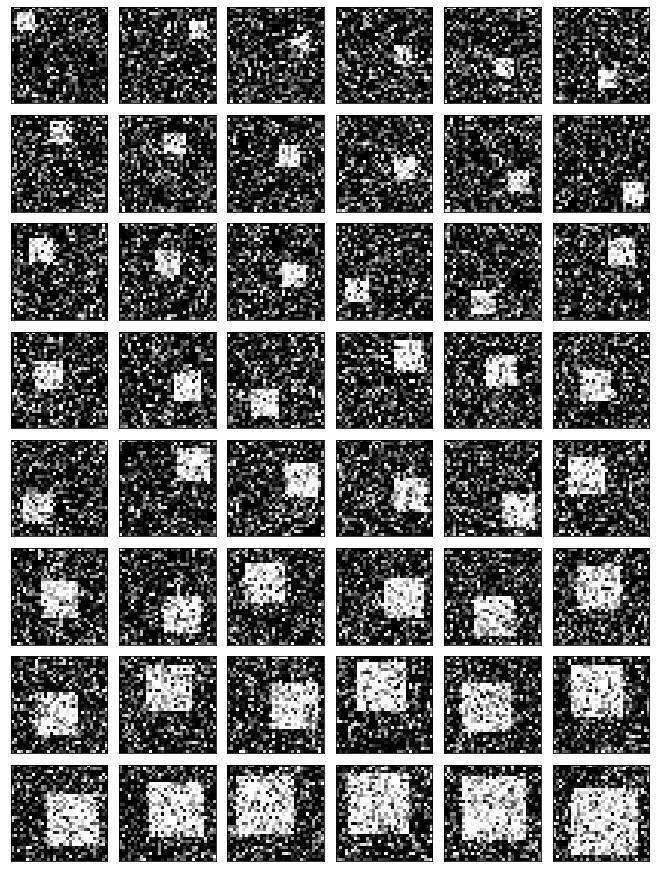


################################################################################
#
# RESULT # 02
#
################################################################################

[plot examples of the training ground truth images]



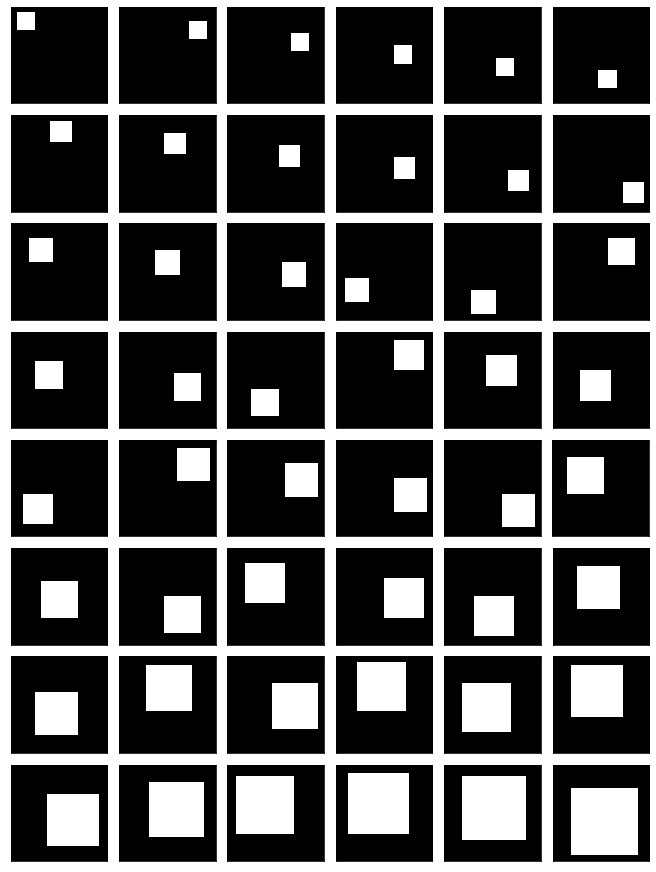


################################################################################
#
# RESULT # 03
#
################################################################################

[plot examples of the training segmentation results]

tensor([[[[-2.1337e+10, -2.1317e+10, -2.1300e+10,  ..., -2.1332e+10,
           -2.1344e+10, -2.1340e+10],
          [-2.1308e+10, -2.1278e+10, -2.1256e+10,  ..., -2.1357e+10,
           -2.1375e+10, -2.1359e+10],
          [-2.1296e+10, -2.1273e+10, -2.1256e+10,  ..., -2.1315e+10,
           -2.1288e+10, -2.1291e+10],
          ...,
          [-1.9180e+10, -1.8480e+10, -1.8594e+10,  ..., -2.1061e+10,
           -2.1021e+10, -2.1119e+10],
          [-1.9531e+10, -1.8978e+10, -1.9135e+10,  ..., -2.0959e+10,
           -2.0900e+10, -2.1028e+10],
          [-2.0029e+10, -1.9579e+10, -1.9655e+10,  ..., -2.0991e+10,
           -2.0929e+10, -2.1044e+10]]],


        [[[-2.1335e+10, -2.1317e+10, -2.1301e+10,  ..., -2.1337e+10,
           -2.1341e+10, -2.1328e+1

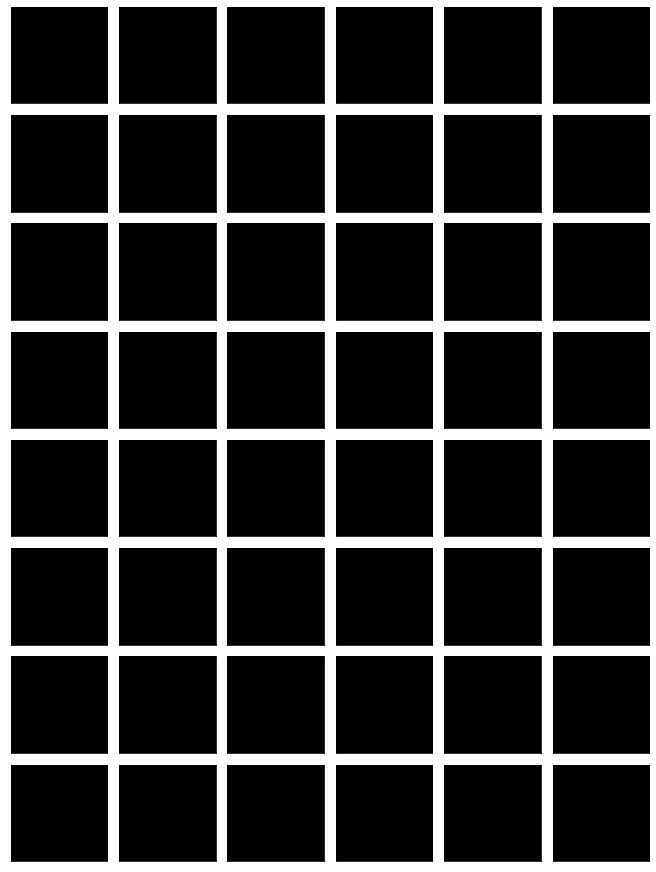


################################################################################
#
# RESULT # 04
#
################################################################################

[plot examples of the testing noisy images]



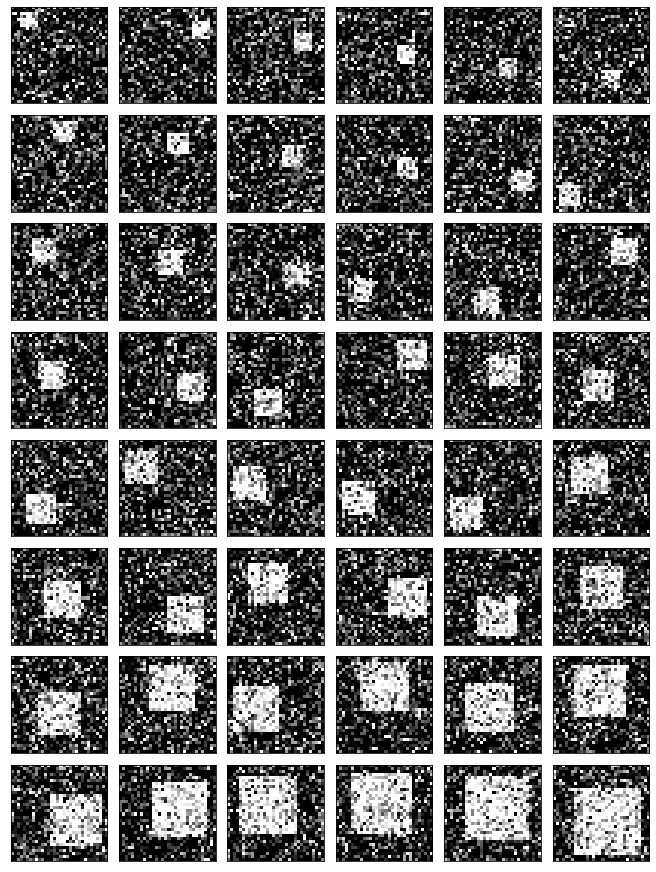


################################################################################
#
# RESULT # 05
#
################################################################################

[plot examples of the testing ground truth images]



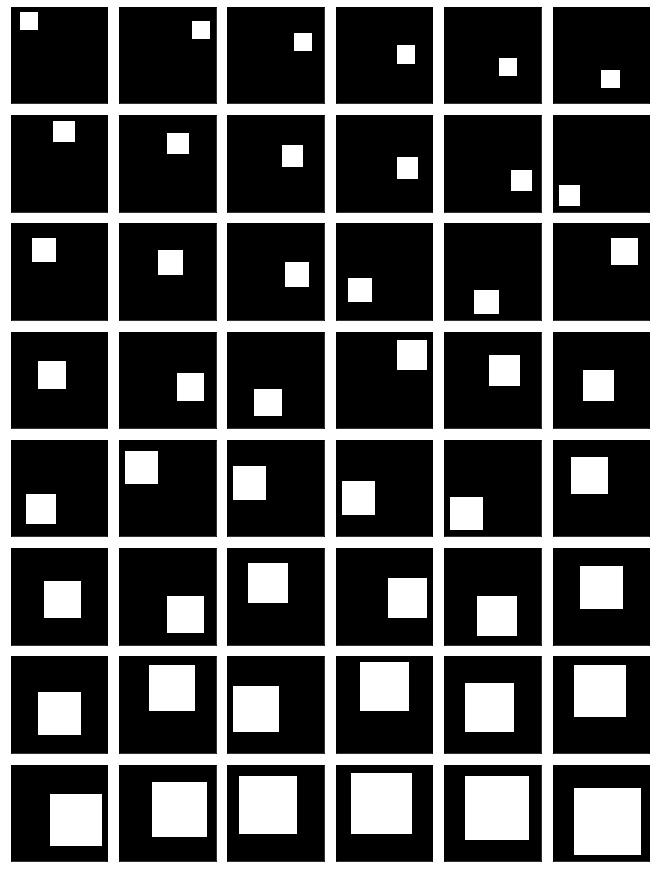


################################################################################
#
# RESULT # 06
#
################################################################################

[plot examples of the testing segmentation results]



KeyboardInterrupt: 

In [710]:
number_result = 16

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1) 
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)